This notebook visualizes CIFAR10 users using various methods of generating simulation users.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import joblib

from ramsay.data.sampling import get_data_sampler
from polya_mixture.datasets.femnist_dataset import _load_h5_into_dict
from polya_mixture.datasets.sampler import DirichletDataSampler

In [2]:
# Helper functions

def load_femnist_as_dict(data_dir):
    h5_file_path = os.path.join(data_dir, 'fed_emnist_train.h5')
    digits_only = False
    numpy_to_tensor = lambda x: x
    user_id_to_data = _load_h5_into_dict(h5_file_path, digits_only,
                                         numpy_to_tensor)
    return user_id_to_data

def get_all_labels(user_id_to_data):
    all_labels = []
    for _, y in user_id_to_data.values():
        all_labels.append(y)
    return np.hstack(all_labels)


def get_femnist_len_sampler(user_id_to_data):
    histo = np.zeros(500)
    for _, y in user_id_to_data.values():
        num_samples = len(y)
        histo[num_samples] += 1

    p = histo / sum(histo) 
    len_sampler = lambda p=p: np.random.choice(range(len(p)), p=p)
    return len_sampler

In [3]:
# Functions to generate users

def generate_true_users(user_id_to_data):
    users = []
    for _, y in user_id_to_data.values():
        labels, counts = np.unique(y, return_counts=True)
        full_y = np.zeros(62)
        full_y[labels] = counts
        users.append(full_y)
    return np.array(users)


def generate_mixture_users(num_users, alphas, phi, num_samples_dists, all_labels):
    users = []
    ks = []
    for _ in range(num_users):
        k = np.random.choice(range(len(alphas)), p=phi)
        d = num_samples_dists[k]
        n = np.random.choice(range(len(d)), p=d)

        sampler = DirichletDataSampler(alphas[k], all_labels)
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_single_dirichlet_users(num_users, alpha, user_len_sampler, all_labels):
    sampler = DirichletDataSampler(alpha, all_labels)
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_uniform_users(num_users, user_len_sampler, all_labels):
    sampler = get_data_sampler('random', len(all_labels))
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

In [4]:
# Load femnist and get all labels
data_dir = 'data/femnist'
user_id_to_data = load_femnist_as_dict(data_dir)
all_labels = get_all_labels(user_id_to_data)

In [5]:
num_users = len(user_id_to_data.keys())

# One mixture component

dict_keys(['alphas', 'phi'])


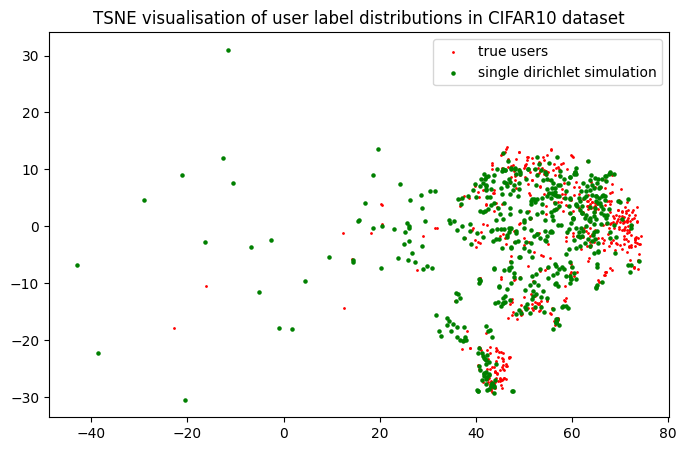

In [16]:
# Load single dirichlet saved params

# load learned parameters
params = joblib.load(os.path.join('mle_params', 'femnist_learn_dirichlet_1_mixture', 'polya-mixture.joblib'))
print(params.keys())
alpha_one_component =  np.array(params['alphas'][0])

num_samples_distribution_one_component = joblib.load(os.path.join('num_samples_distribution', 'femnist_learn_dirichlet_1_mixture.joblib'))
num_samples_distribution_one_component = num_samples_distribution_one_component.numpy().reshape(-1,)

len_sampler = lambda: np.random.choice(range(len(num_samples_distribution_one_component)), p=num_samples_distribution_one_component)

# create distributions
true_users = generate_true_users(user_id_to_data)
simulated_single_dirichlet_users = generate_single_dirichlet_users(len(true_users), alpha_one_component, len_sampler, all_labels)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_single_dirichlet_users])#, simulated_uniform_users])
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single dirichlet simulation')
#plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

# Two mixture components

dict_keys(['alphas', 'phi'])
alpha_mixture [[12.486713  13.534921  11.7629795 12.550145  11.480532  10.293059
  11.921352  12.587899  11.840125  11.941666   3.9614604  2.2822833
   7.3454185  2.6096861  2.1497195  6.5782847  1.219504   1.6149502
   8.219717   2.2317927  1.2118896  2.750498   6.845294   5.16876
  20.386126   6.246426   1.2428675  2.2957945 16.824781   6.5312443
   9.8076315  2.787484   3.030136   1.3144614  2.9685311  1.3412713
   6.926577   3.528872   1.3654627  7.718317  19.724745   1.1862212
   2.2440865  6.1563945  1.3286887  1.0327483  1.2686301  9.836655
   1.2492453  7.9961534  1.320585   1.1531479  1.781072  10.346889
   1.3283604 14.271842   1.3694632  1.4000323  1.3433177  1.3627586
   1.2021077  1.3795127]
 [44.51527   50.686996  45.006035  45.453217  44.310375  41.812286
  45.320396  47.128685  44.48823   44.521595   3.9697187  3.7719092
   4.3950214  3.7158391  3.4485605  3.7217412  3.4760392  3.436453
   5.725511   3.7413826  3.4088106  4.3864307  3.745093

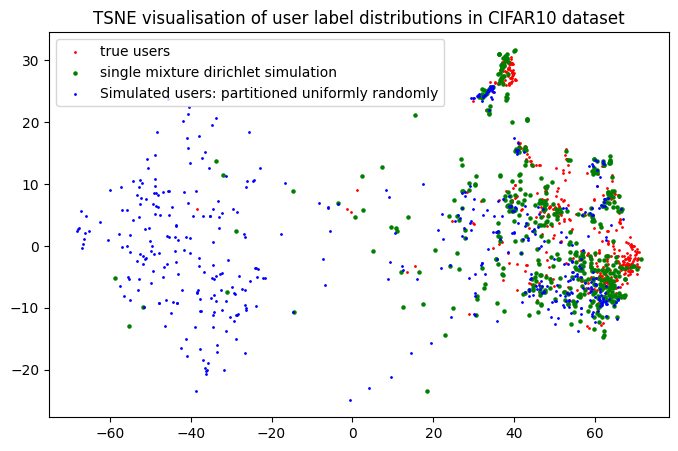

In [17]:
# Load two component mixture dirichlet saved params
params = joblib.load(os.path.join('mle_params', 'femnist_2_mixture', 'polya-mixture.joblib'))
print(params.keys())
alpha_mixture =  np.array(params['alphas'])
print('alpha_mixture', alpha_mixture)
phi_mixture = np.array(params['phi'])
phi_mixture /= sum(phi_mixture)
print('phi_mixture', phi_mixture)

num_samples_distribution_mixture = joblib.load(os.path.join('num_samples_distribution', 'femnist_2_mixture.joblib'))
num_samples_distribution_mixture = num_samples_distribution_mixture.numpy()
print('num_samples_distribution_mixture', num_samples_distribution_mixture.shape)
print(phi_mixture.shape, alpha_mixture.shape, num_samples_distribution_mixture.shape)

# generate users
num_users = 500
true_users = generate_true_users(user_id_to_data)
simulated_dirichlet_mixture_users = generate_mixture_users(len(true_users), alpha_mixture, phi_mixture, num_samples_distribution_mixture, all_labels)
len_sampler = get_femnist_len_sampler(user_id_to_data)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_dirichlet_mixture_users, simulated_uniform_users]) 
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

# plot
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

# Three mixture components

dict_keys(['alphas', 'phi'])
alpha_mixture [[ 7.331553    7.954057    6.9863634   7.491554    6.840809    6.176658
   7.037211    7.3866696   7.0418634   7.0186877   1.7180551   1.3936192
   4.336823    1.3972884   1.021399    3.9414258   0.8377679   0.8865488
   4.666944    1.3927824   0.82493305  1.5903513   4.075701    2.323618
  11.663883    3.662332    0.8683789   0.9965437   9.724308    3.1967835
   5.7382493   1.7378958   1.9411799   0.8642131   1.9035438   0.8644596
   4.9368877   2.3315918   0.90976584  5.0233307  12.5443945   0.7650201
   1.4112251   4.09973     0.91791886  0.70593554  0.8813811   5.6781783
   0.82670665  5.477468    0.91935456  0.7856333   1.1689324   7.026988
   0.83059084  9.19348     0.8955782   0.8933723   0.8802291   0.93215483
   0.79196453  0.9271174 ]
 [18.83051    21.391619   19.192364   19.395418   18.862967   18.080807
  19.338434   20.053724   18.768417   19.05818     1.8996079   1.8278965
   2.0523577   1.8387978   1.6229041   1.7828559   1.7393

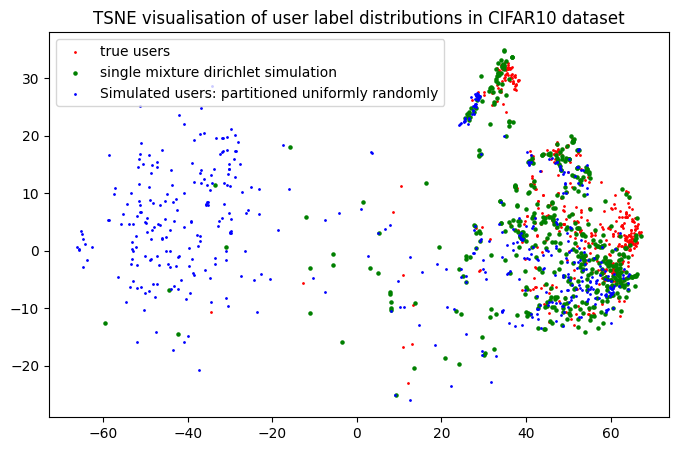

In [18]:
# Load three component mixture dirichlet saved params
num_mixture_components = 3

params = joblib.load(os.path.join('mle_params', f'femnist_{num_mixture_components}_mixture', 'polya-mixture.joblib'))
print(params.keys())
alpha_mixture =  np.array(params['alphas'])
print('alpha_mixture', alpha_mixture)
phi_mixture = np.array(params['phi'])
phi_mixture /= sum(phi_mixture)
print('phi_mixture', phi_mixture)

num_samples_distribution_mixture = joblib.load(os.path.join('num_samples_distribution', f'femnist_{num_mixture_components}_mixture.joblib'))
num_samples_distribution_mixture = num_samples_distribution_mixture.numpy()
print('num_samples_distribution_mixture', num_samples_distribution_mixture.shape)
print(phi_mixture.shape, alpha_mixture.shape, num_samples_distribution_mixture.shape)

# generate users
num_users = 500
true_users = generate_true_users(user_id_to_data)
simulated_dirichlet_mixture_users = generate_mixture_users(len(true_users), alpha_mixture, phi_mixture, num_samples_distribution_mixture, all_labels)
len_sampler = get_femnist_len_sampler(user_id_to_data)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_dirichlet_mixture_users, simulated_uniform_users]) 
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

# plot
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

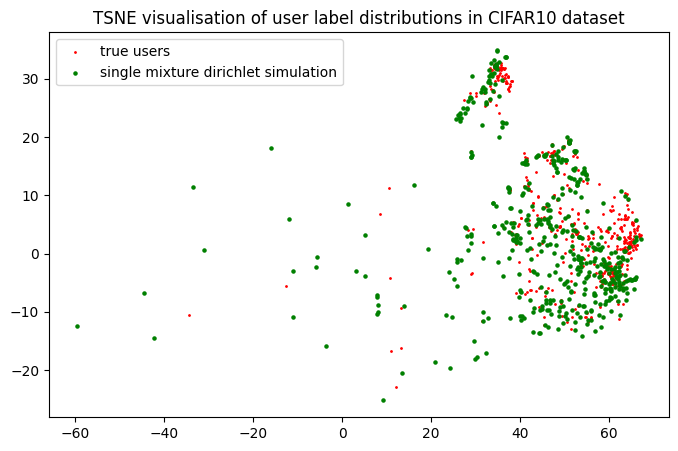

In [19]:
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
#plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)